In [454]:
import datetime, warnings, scipy 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:**
- Fecha-I : Fecha y hora programada del vuelo. 
- Vlo-I : Número de vuelo programado. 
- Ori-I : Código de ciudad de origen programado. 
- Des-I : Código de ciudad de destino programado. 
- Emp-I : Código aerolínea de vuelo programado. 
- Fecha-O : Fecha y hora de operación del vuelo.
- Vlo-O : Número de vuelo de operación del vuelo. 
- Ori-O : Código de ciudad de origen de operación 
- Des-O : Código de ciudad de destino de operación. 
- Emp-O : Código aerolínea de vuelo operado. 
- DIA : Día del mes de operación del vuelo. 
- MES : Número de mes de operación del vuelo. 
- AÑO : Año de operación del vuelo. 
- DIANOM : Día de la semana de operación del vuelo. 
- TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional. 
- OPERA : Nombre de aerolínea que opera. 
- SIGLAORI : Nombre ciudad origen. 
- SIGLADES : Nombre ciudad destino.

# Lectura de datos y revisión inicial

In [409]:
# Leemos data frame, vemos sus dimensiones y primeras 5 observaciones
df = pd.read_csv('dataset_SCL.csv')
print('Dimensiones:', df.shape)
df.head()

Dimensiones: (68206, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [410]:
# Sólo tenemos un origen, Santiago
df.SIGLAORI.unique()

array(['Santiago'], dtype=object)

- En el chunck de más abajo vemos de qué tipo es cada variable, se destaca que variables de Fecha-I y Fecha-O son variables de tipo string, por lo que posteriormente necesitarán una transformación a serie de tiempo.
- Revisamos además si el data frame tiene valores perdidos, en este caso sólo existe una observación perdida en la variable Vlo-O, ésta corresponde al número de vuelo de operación del vuelo, variable que no se usará porsteriormente ya que es sólo un valor arbitrario asignado que no entrega información para el problema objetivo (inferencia en base sólo al conocimiento que es posible deducir con la información que se tiene en el data frame).

In [411]:
print(df.dtypes)
print('-'*30)
print(df.isnull().sum())

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object
------------------------------
Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


# 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

Tenemos sólo Santiago como origen de vuelos asociado a la siguiente cantidad de variables categóricas:

In [412]:
# Creamos variable para visualizar la frecuencia en general de vuelos por cada mes
df['año_mes'] = df['AÑO'].astype(str) + '_' + df['MES'].astype(str)

print('Único origen de vuelos en desde {}'.format(df.SIGLAORI.unique()[0]))
print('Hay un total de {} destinos'.format(len(df.SIGLADES.unique())))
print('Hay un total de {} operadores'.format(len(df.OPERA.unique())))
print('Hay un total de {} meses'.format(len(df.año_mes.unique())))
print('Hay un total de {} tipos de vuelo'.format(len(df.TIPOVUELO.unique())))

Único origen de vuelos en desde Santiago
Hay un total de 62 destinos
Hay un total de 23 operadores
Hay un total de 13 meses
Hay un total de 2 tipos de vuelo


Creamos función para realizar gráficos de frecuencia para las distintas variables categóricas

In [413]:
# Creamos función que genera gráficos de barra de frecuenciay lista con cantidad de vuelos por clase
def plot_by_cat(df, var, cat=[]):
    if len(cat) > 0:
        cats = df[cat].unique()
        for i in cats:
            plt.figure(figsize=(9, 4.5))
            df[df[cat]==i][var].value_counts().plot(kind='bar')
            plt.title('Frecuencia vuelos Santiago a todos los destinos por '+ str(cat)+ ' = ' + str(i))
            plt.grid(True)
            plt.show()
            display(df[df[cat]==i][var].value_counts())
    else:
        plt.figure(figsize=(13, 5))
        df[var].value_counts().plot(kind='bar')
        plt.title('Frecuencia vuelos Santiago a todos los destinos por '+ str(var))
        plt.grid(True)
        plt.show()
        display(df[var].value_counts())

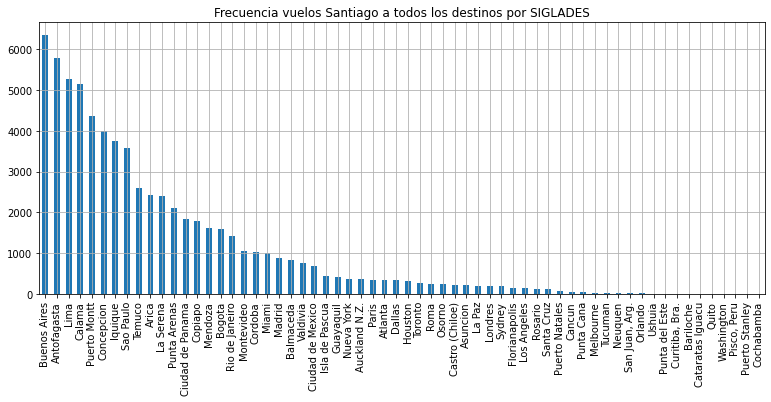

Buenos Aires      6335
Antofagasta       5786
Lima              5270
Calama            5146
Puerto Montt      4357
                  ... 
Quito                2
Washington           1
Pisco, Peru          1
Puerto Stanley       1
Cochabamba           1
Name: SIGLADES, Length: 62, dtype: int64

In [414]:
# Frecuencia a todos los destinos
plot_by_cat(df, var='SIGLADES')

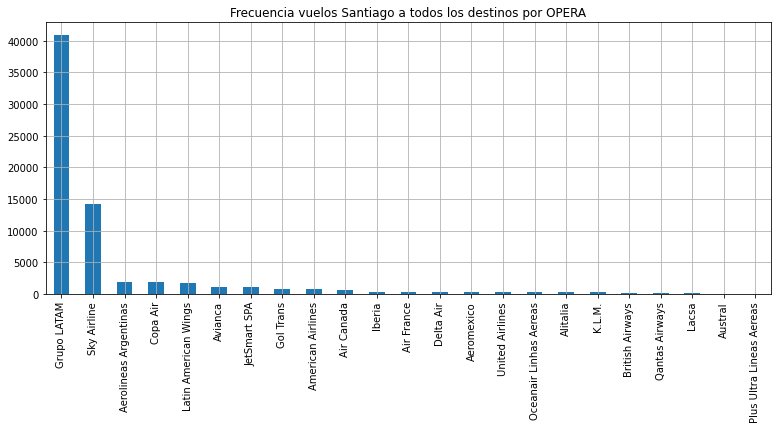

Grupo LATAM                 40892
Sky Airline                 14298
Aerolineas Argentinas        1949
Copa Air                     1850
Latin American Wings         1674
Avianca                      1152
JetSmart SPA                 1095
Gol Trans                     806
American Airlines             757
Air Canada                    565
Iberia                        362
Air France                    358
Delta Air                     358
Aeromexico                    351
United Airlines               335
Oceanair Linhas Aereas        279
Alitalia                      259
K.L.M.                        251
British Airways               205
Qantas Airways                195
Lacsa                          92
Austral                        74
Plus Ultra Lineas Aereas       49
Name: OPERA, dtype: int64

In [415]:
# Frecuencia de vuelos por aerolinea que opera
plot_by_cat(df, var='OPERA')

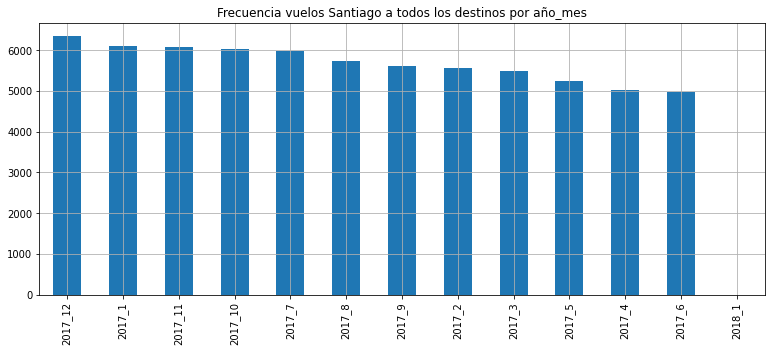

2017_12    6356
2017_1     6106
2017_11    6080
2017_10    6032
2017_7     5992
2017_8     5744
2017_9     5610
2017_2     5561
2017_3     5482
2017_5     5240
2017_4     5020
2017_6     4981
2018_1        2
Name: año_mes, dtype: int64

In [416]:
plot_by_cat(df, var='año_mes')

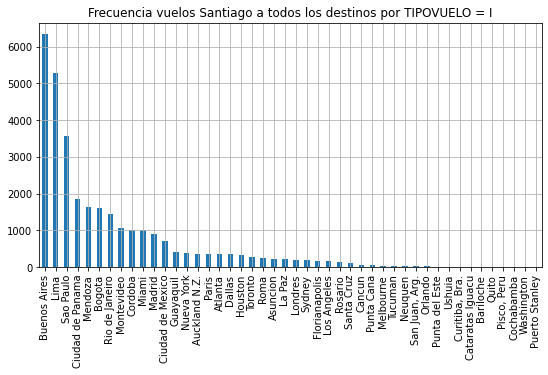

Buenos Aires        6335
Lima                5270
Sao Paulo           3569
Ciudad de Panama    1850
Mendoza             1625
Bogota              1604
Rio de Janeiro      1435
Montevideo          1066
Cordoba             1023
Miami               1016
Madrid               894
Ciudad de Mexico     700
Guayaquil            422
Nueva York           382
Auckland N.Z.        361
Paris                359
Atlanta              358
Dallas               357
Houston              334
Toronto              283
Roma                 259
Asuncion             232
La Paz               209
Londres              205
Sydney               194
Florianapolis        162
Los Angeles          155
Rosario              136
Santa Cruz           120
Cancun                63
Punta Cana            54
Melbourne             39
Tucuman               38
Neuquen               37
San Juan, Arg.        35
Orlando               34
Punta del Este         6
Ushuia                 6
Curitiba, Bra.         3
Cataratas Iguacu       2


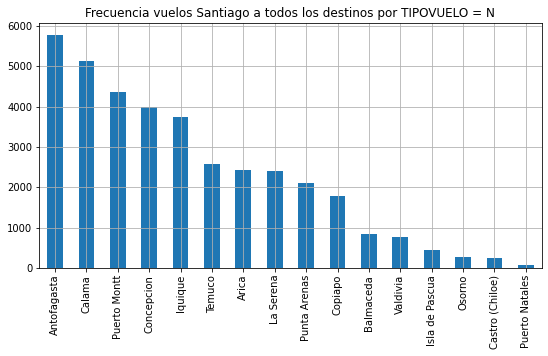

Antofagasta        5786
Calama             5146
Puerto Montt       4357
Concepcion         3993
Iquique            3747
Temuco             2589
Arica              2436
La Serena          2410
Punta Arenas       2105
Copiapo            1780
Balmaceda           839
Valdivia            753
Isla de Pascua      452
Osorno              259
Castro (Chiloe)     235
Puerto Natales       79
Name: SIGLADES, dtype: int64

In [417]:
# Frecuencia de vuelos por tipo de vuelo
plot_by_cat(df, var='SIGLADES', cat='TIPOVUELO')

- Para la variable SIGLADES se observa que dentro de los 10 destinos con mayor frecuencia de vuelos 7 son dentro del país y 3 en latinoamérica, siendo el destino con mayor frecuencia Buenos Aires seguido de Antofagasta. Ya en el puesto 20 aparece Miami como el destino con mayor frecuencia fuera de latinoamérica. Posterior a esto las frecuencias bajan significativamente.
- El operador que con ventaja posee la mayor frecuencia de vuelos es el Grupo LATAM, seguido por Sky Airline que ya baja a tener menos de un 30% de la frecuencia de Grupo LATAM. Luego de éstas la frecuencia de vuelos ya pasa a ser bastante más reducida en el resto de operadores.
- En los meses la frecuencia es bastante más balanceada aunque se puede observar una leve tendencia a tenes más vuelos los meses de primavera y verano (octubre, noviembre, diciembre y enero).
- Finalmente para los tipos de vuelo, en los internacionales los 9 principales destinos son en latinoamérica dando paso luego a Miami y Madrid, bajando luego de forma más drástica a frecuencia a otros destinos. En cuanto a los nacionales las diferencias de frecuencia no son tan marcadas como en los internacionales, siendo los tres principales destinos Antofagasta-Calama-Puerto Montt, y los tres menos frecuentados Osorno-Castro-Puerto Natales.

Como conclusión general se ve que existe un gran desbalance de cantidad de observaciones en las categorías, a excepción de los meses, por lo que probablemente luego de ahondar más en la exploración de los datos sea necesatio usar agupaciones de éstos que generalicen más las clases y/o directamente eliminar algunas categorías minoritarias.

# 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15: 1 si dif_min > 15, 0 si no.
- periodo_dia: mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I

In [418]:
# Convertimos columnas de fecha programados y operados de string seríe de tiempo
df['Fecha-I'], df['Fecha-O'] = pd.to_datetime(df['Fecha-I']), pd.to_datetime(df['Fecha-O'])

In [419]:
# temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
df['temporada_alta'] = np.where( (df['Fecha-I']>='2017-12-15') | (df['Fecha-I']<='2017-03-03'), 1,
                       np.where( (df['Fecha-I']>='2017-07-15') & (df['Fecha-I']<='2017-07-31'), 1, 
                       np.where( (df['Fecha-I']>='2017-09-11') & (df['Fecha-I']<='2017-09-30'), 1, 0)))

# dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
df['dif_min'] = (df['Fecha-O']-df['Fecha-I']).astype('timedelta64[m]')

# atraso_15: 1 si dif_min > 15, 0 si no.
df['atraso_15'] = np.where(df['dif_min']>15, 1, 0)

# periodo_dia: mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I
df['time'] = df['Fecha-I'].dt.time # creamos columna que contiene sólo el tiempo
df['periodo_dia'] = np.where( (df['time']>=datetime.time(5, 0)) & (df['time']<=datetime.time(11, 59)), 'mañana',
                    np.where( (df['time']>=datetime.time(12, 0)) & (df['time']<=datetime.time(18, 59)), 'tarde', 'noche' ))

df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,año_mes,temporada_alta,dif_min,atraso_15,time,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017_1,1,3.0,0,23:30:00,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017_1,1,9.0,0,23:30:00,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017_1,1,9.0,0,23:30:00,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017_1,1,3.0,0,23:30:00,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017_1,1,-2.0,0,23:30:00,noche


In [420]:
# Exportamos nuevos features en synthetic_features.csv
df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']].to_csv('synthetic_features.csv', index=False)

# 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

In [421]:
# función auxiliar para estadística descriptida de atrasos
def get_stats(group):
    return {'count': group.count(), 'min': np.min(group), 'p10': np.percentile(group,10), 'mean': round(group.mean(), 1), 
            'median': group.median(), 'p90': np.percentile(group,90),'max': np.max(group)
            }

# Creamos función para histogramas
def plot_by_cat_hist(df, var, cat=[]):
    max_y, min_y = df[var].max(), df[var].min()
    cats = df[cat].unique()
    
    global_stats = df[var].groupby(df[cat]).apply(get_stats).unstack()
    global_stats = global_stats.sort_values('mean')
    display(global_stats)
    
    for i in cats:
        variable = df[df[cat]==i][var]
        plt.figure(figsize=(7, 4))
        plt.hist(variable, bins= 30, rwidth=0.95, color='#607c8e')
        plt.xlim(min_y, max_y)
        
        plt.axvline(variable.median(), color='red', linestyle='dashed', linewidth=2)
        plt.axvline(variable.mean(), color='blue', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(variable,10), color='gray', linestyle='dashed', linewidth=2)
        plt.axvline(np.percentile(variable,90), color='gray', linestyle='dashed', linewidth=2)
        
        min_ylim, max_ylim = plt.ylim() # para agregar valor en grafico
        plt.text(100, max_ylim*0.90, 'Valores en minutos')
        plt.text(100, max_ylim*0.84, 'Mean: {:.0f}'.format(variable.mean()))
        plt.text(100, max_ylim*0.78, 'Median: {:.0f}'.format(variable.median()))
        plt.text(100, max_ylim*0.72, 'Per.10: {:.0f}'.format(np.percentile(variable,10)))
        plt.text(100, max_ylim*0.66, 'Per.90: {:.0f}'.format(np.percentile(variable,90)))
        
        plt.title('Frecuencia tasa de atrasos para '+ str(cat)+ ' = ' + str(i) + ' (n = '+ str(len(variable)) + ')')
        plt.grid(True)
        plt.show()

**Para efectos de hacer una revisión más parsimoniosa y de apuntar a las clases que tienen mayor representación, se genera un nuevo data frame donde se eliminará las clases con un procentaje de frecuencia menor al 1% en las variables SIGLADES y OPERA, además se eliminarán las dos observaciones de enero de 2018.**

**El fin último de esto es, que al ser sus frecuencias marginales pueden introducir sesgos en el análisis y en la etapa de modelación.**

In [422]:
# Función para generar lista de clases con frecuencia mayor a 3%
def per_filter(df, var):
    siglades_per = df[var].value_counts('%')*100
    var_index = []
    for i, j in enumerate(siglades_per):
        if j>1:
            var_index.append(i)
            
    return siglades_per.index[var_index]

**Finalmente nos quedaremos con los destinos y operadores que se enlistan en el siguiente chunck**

In [423]:
list_siglades, list_opera = per_filter(df, 'SIGLADES'), per_filter(df, 'OPERA')
print('Destinos con frecuencia mayor a 3%: \n', list_siglades)
print('-'*60)
print('Operadores con frecuencia mayor a 3%: \n', list_opera)

Destinos con frecuencia mayor a 3%: 
 Index(['Buenos Aires', 'Antofagasta', 'Lima', 'Calama', 'Puerto Montt',
       'Concepcion', 'Iquique', 'Sao Paulo', 'Temuco', 'Arica', 'La Serena',
       'Punta Arenas', 'Ciudad de Panama', 'Copiapo', 'Mendoza', 'Bogota',
       'Rio de Janeiro', 'Montevideo', 'Cordoba', 'Miami', 'Madrid',
       'Balmaceda', 'Valdivia', 'Ciudad de Mexico'],
      dtype='object')
------------------------------------------------------------
Operadores con frecuencia mayor a 3%: 
 Index(['Grupo LATAM', 'Sky Airline', 'Aerolineas Argentinas', 'Copa Air',
       'Latin American Wings', 'Avianca', 'JetSmart SPA', 'Gol Trans',
       'American Airlines'],
      dtype='object')


In [424]:
# Filtramos data con nuevas listas de categorías con baja frecuencia
past_rows = df.shape[0]
df = df[ (df['SIGLADES'].isin(list_siglades)) & (df['OPERA'].isin(list_opera)) ]
df = df[df['año_mes']!='2018_1']
print('Luego de filtro pasamos de {} observaciones a {}'.format(past_rows, df.shape[0]))

Luego de filtro pasamos de 68206 observaciones a 60589


**Atrasos por destino**

,count,min,p10,mean,median,p90,max
SIGLADES,,,,,,,
Ciudad de Panama,1850.0,-14.0,-10.0,0.2,-2.0,10.0,151.0
Calama,5146.0,-14.0,-3.0,6.0,2.0,18.0,161.0
Antofagasta,5786.0,-13.0,-3.0,7.0,2.0,21.0,161.0
Arica,2436.0,-13.0,-3.0,7.1,3.0,20.0,159.0
Copiapo,1780.0,-14.0,-3.0,7.2,3.0,19.1,148.0
Valdivia,753.0,-10.0,-3.0,8.0,2.0,23.0,147.0
La Serena,2410.0,-13.0,-3.0,8.1,3.0,23.0,155.0
Temuco,2589.0,-10.0,-3.0,8.2,4.0,21.0,158.0
Concepcion,3993.0,-14.0,-3.0,8.3,3.0,22.0,161.0


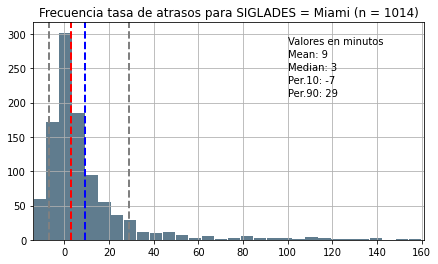

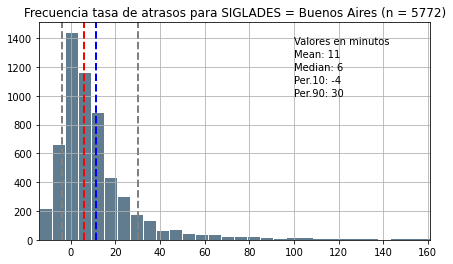

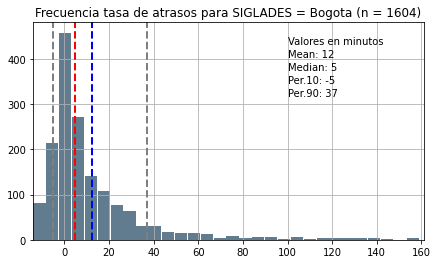

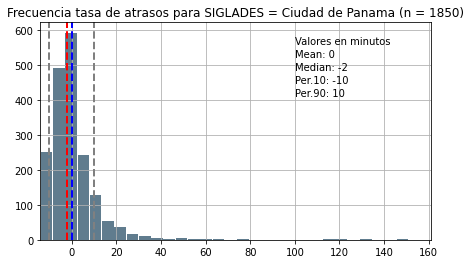

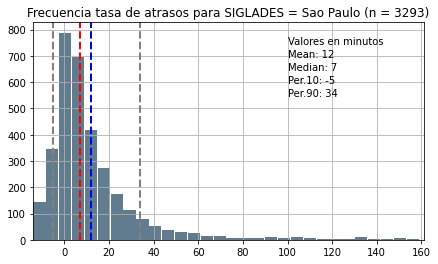

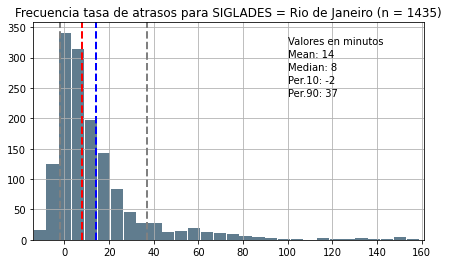

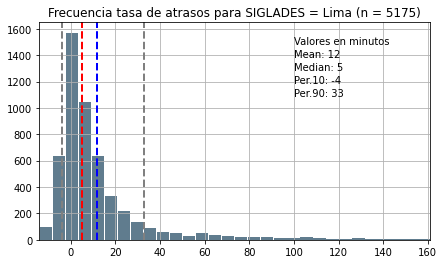

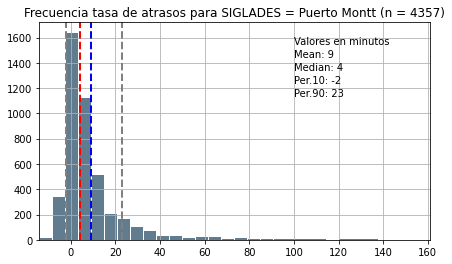

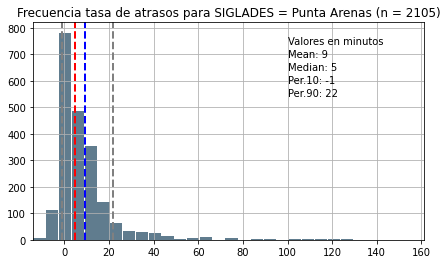

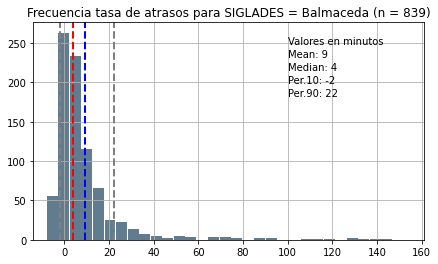

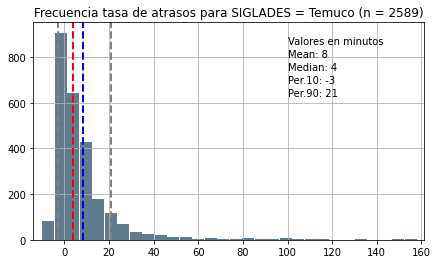

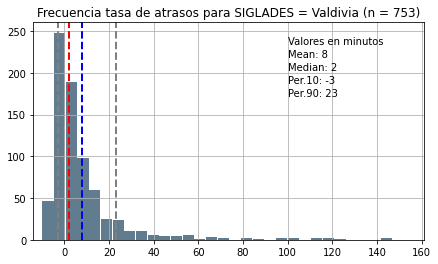

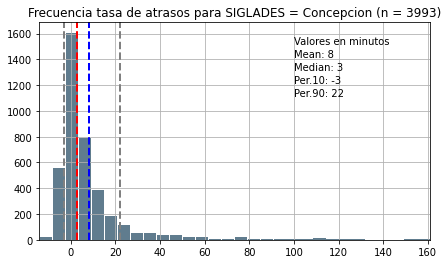

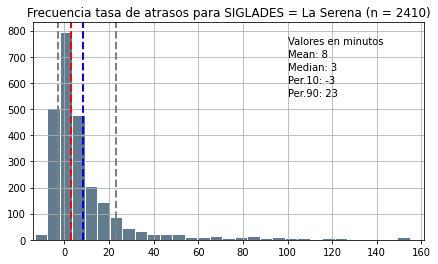

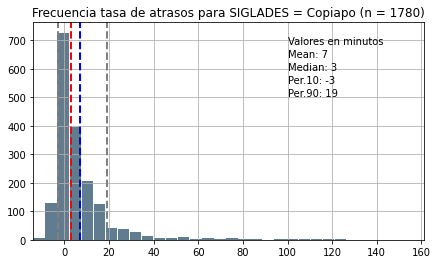

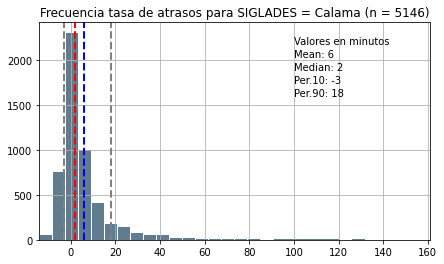

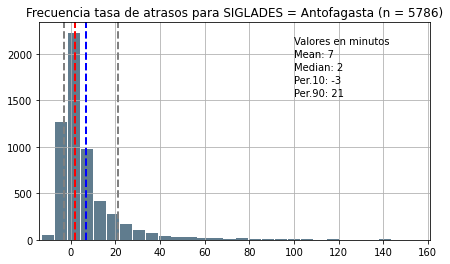

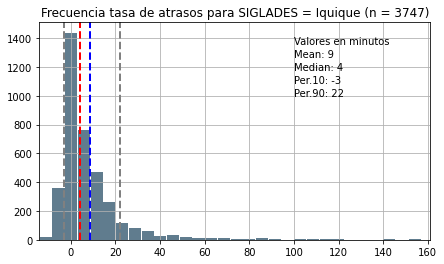

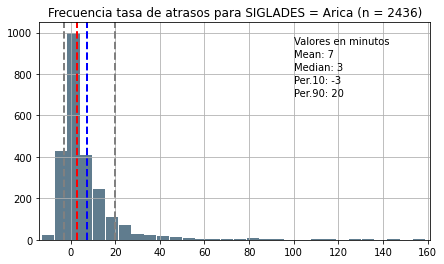

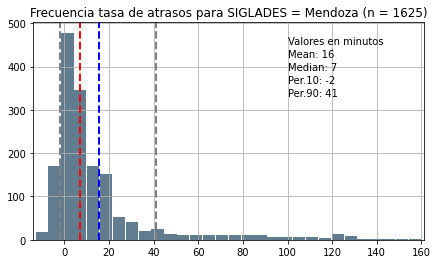

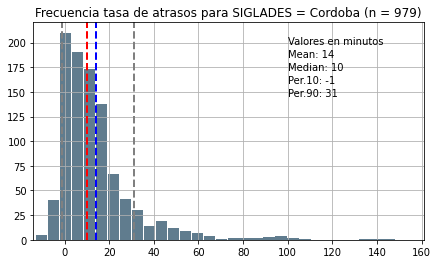

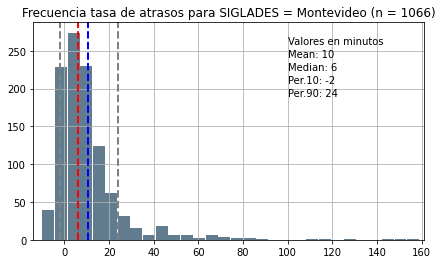

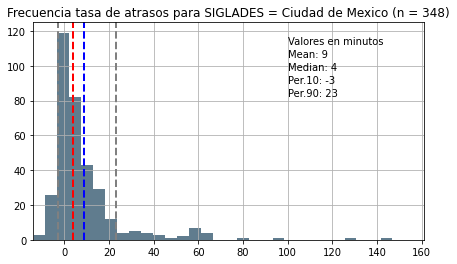

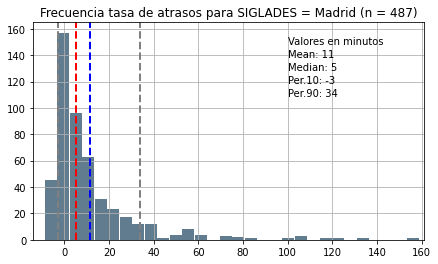

In [425]:
plot_by_cat_hist(df, var='dif_min', cat='SIGLADES')

**Atrasos por aerolínea**

,count,min,p10,mean,median,p90,max
OPERA,,,,,,,
Copa Air,1850.0,-14.0,-10.0,0.2,-2.0,10.0,151.0
American Airlines,400.0,-14.0,-9.0,1.5,-2.0,9.0,160.0
JetSmart SPA,1095.0,-13.0,-5.0,7.4,2.0,23.0,155.0
Sky Airline,14105.0,-14.0,-4.0,8.1,2.0,25.0,161.0
Grupo LATAM,37570.0,-14.0,-2.0,9.3,4.0,23.0,161.0
Aerolineas Argentinas,1949.0,-14.0,-8.0,10.0,3.0,34.0,154.0
Avianca,1152.0,-14.0,-8.0,11.1,2.5,37.0,159.0
Gol Trans,794.0,-14.0,-11.0,12.2,6.0,39.7,151.0
Latin American Wings,1674.0,-14.0,-5.0,24.6,9.0,81.0,161.0


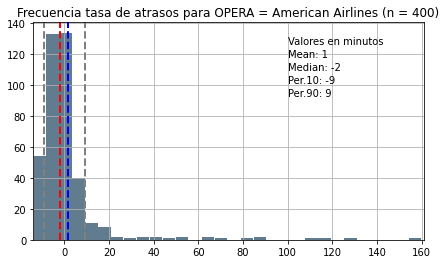

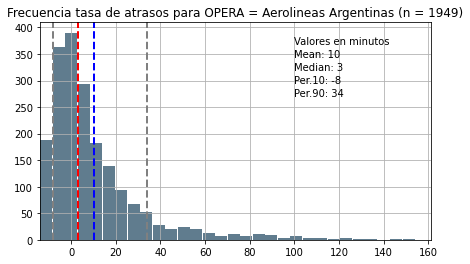

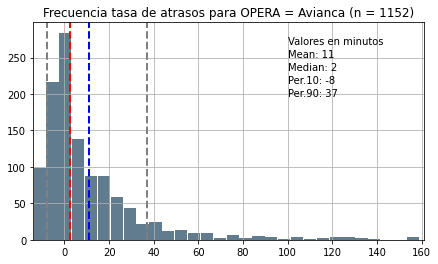

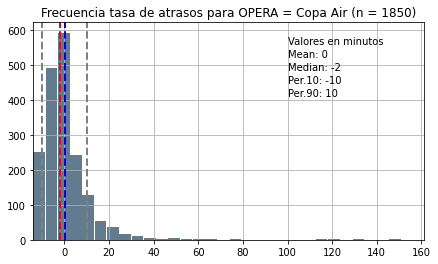

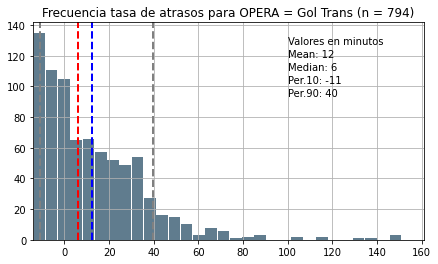

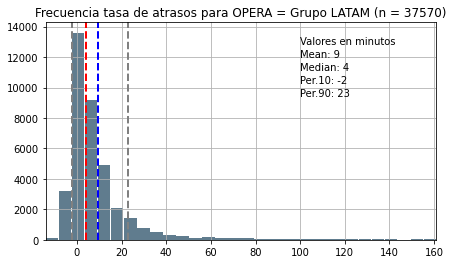

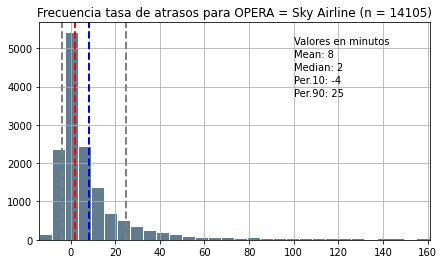

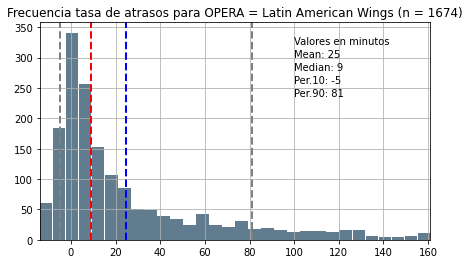

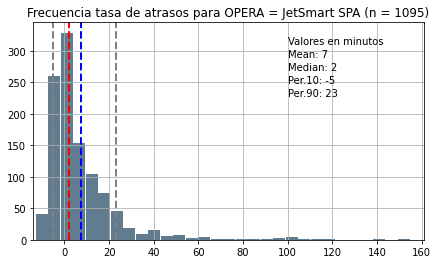

In [426]:
plot_by_cat_hist(df, var='dif_min', cat='OPERA')

**Atrasos por mes del año**

,count,min,p10,mean,median,p90,max
año_mes,,,,,,,
2017_3,4913.0,-14.0,-4.0,5.6,2.0,17.0,159.0
2017_4,4489.0,-14.0,-4.0,5.9,2.0,17.0,161.0
2017_1,5457.0,-14.0,-4.0,7.1,3.0,20.0,161.0
2017_2,4964.0,-14.0,-4.0,7.4,3.0,20.0,160.0
2017_5,4713.0,-14.0,-3.0,7.7,3.0,22.0,161.0
2017_8,5091.0,-14.0,-3.0,8.6,3.0,25.0,161.0
2017_6,4463.0,-14.0,-4.0,8.7,3.0,24.0,161.0
2017_9,4944.0,-14.0,-4.0,8.7,3.0,24.0,157.0
2017_11,5370.0,-14.0,-3.0,9.6,5.0,26.0,161.0


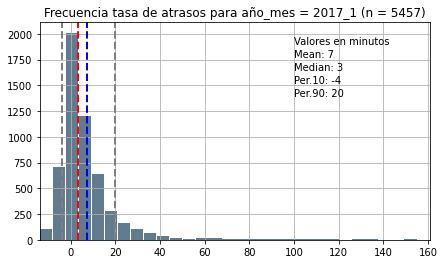

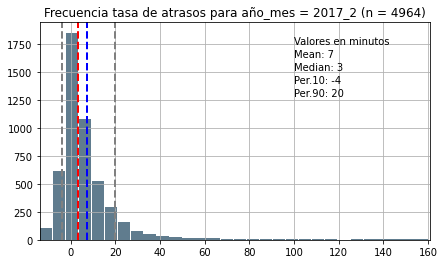

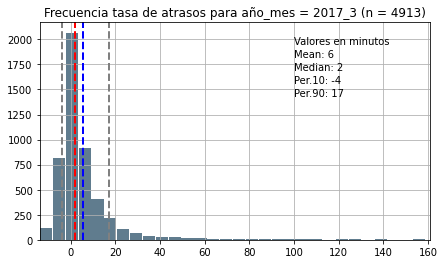

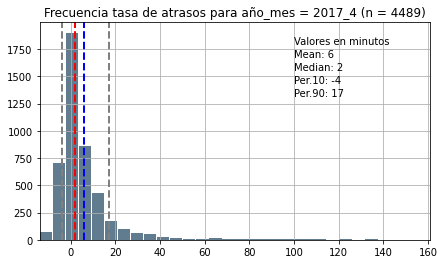

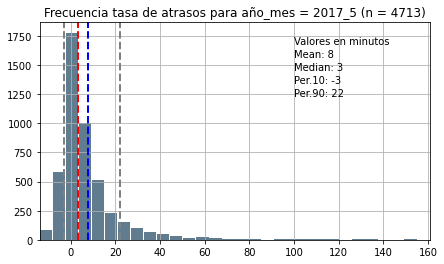

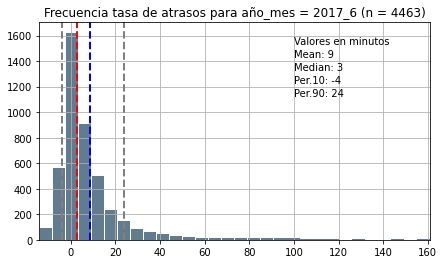

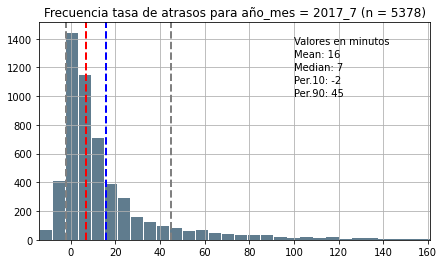

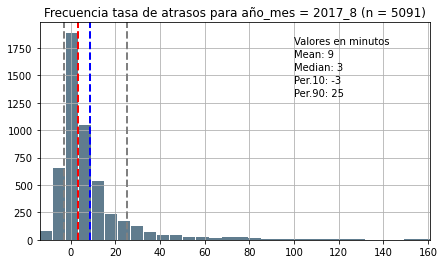

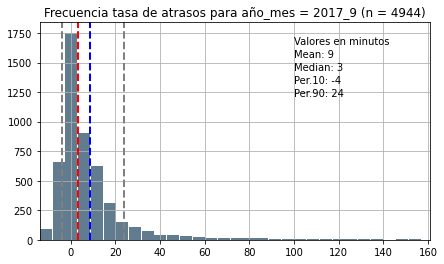

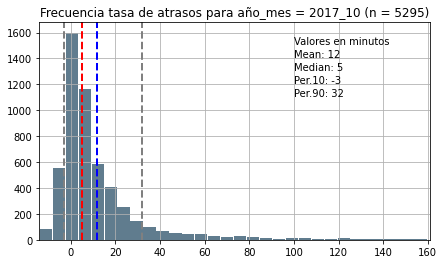

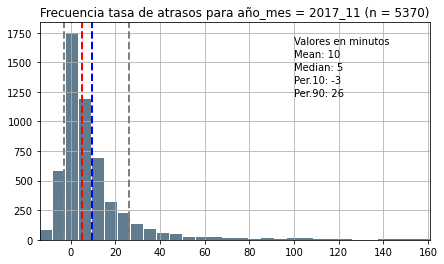

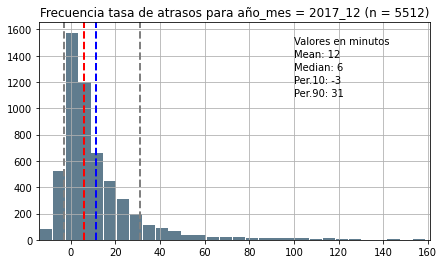

In [427]:
plot_by_cat_hist(df, var='dif_min', cat='año_mes')

**Atrasos por día de la semana**

,count,min,p10,mean,median,p90,max
DIANOM,,,,,,,
Domingo,8637.0,-14.0,-4.0,7.6,3.0,21.0,161.0
Martes,8566.0,-14.0,-4.0,8.4,3.0,23.0,161.0
Sabado,7212.0,-14.0,-4.0,8.4,3.0,22.0,160.0
Miercoles,8680.0,-14.0,-3.0,8.6,4.0,24.0,160.0
Jueves,9205.0,-14.0,-3.0,9.6,4.0,27.0,159.0
Lunes,9105.0,-14.0,-3.0,10.1,4.0,28.0,161.0
Viernes,9184.0,-14.0,-3.0,10.9,5.0,29.0,161.0


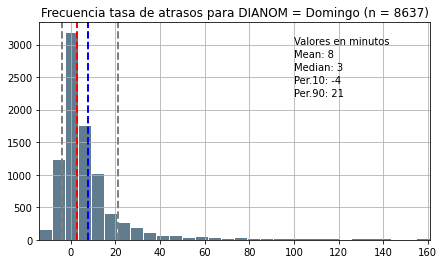

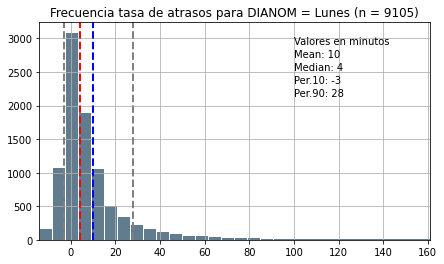

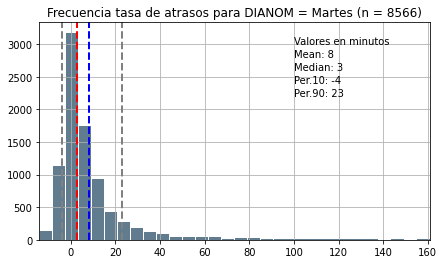

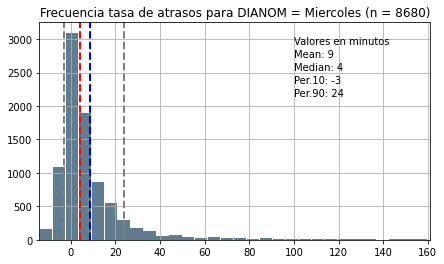

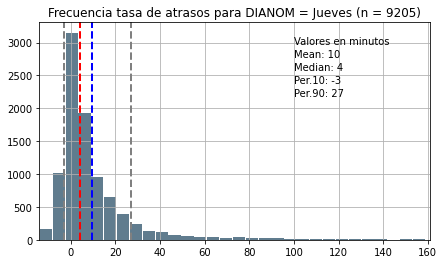

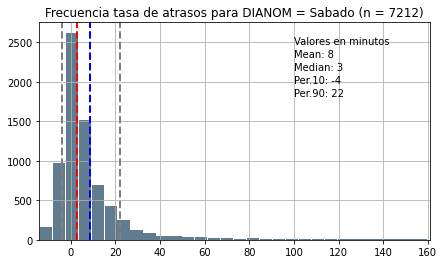

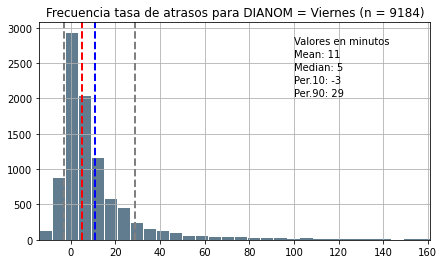

In [428]:
plot_by_cat_hist(df, var='dif_min', cat='DIANOM')

**Atrasos por temporada**

,count,min,p10,mean,median,p90,max
temporada_alta,,,,,,,
0,40872.0,-14.0,-3.0,9.0,4.0,25.0,161.0
1,19717.0,-14.0,-3.0,9.4,4.0,25.0,161.0


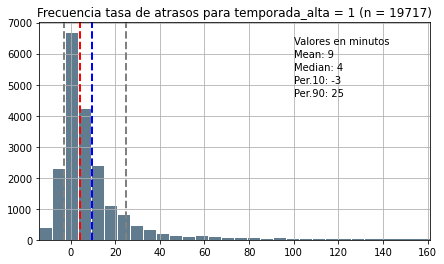

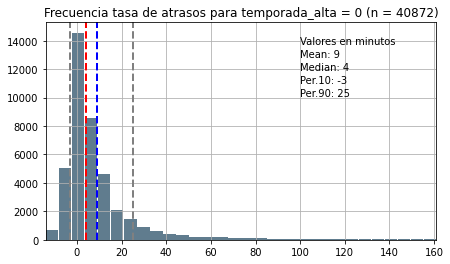

In [429]:
plot_by_cat_hist(df, var='dif_min', cat='temporada_alta')

**Atrasos por tipo de vuelo**

,count,min,p10,mean,median,p90,max
TIPOVUELO,,,,,,,
N,35941.0,-14.0,-3.0,7.8,3.0,21.0,161.0
I,24648.0,-14.0,-5.0,11.1,5.0,31.0,161.0


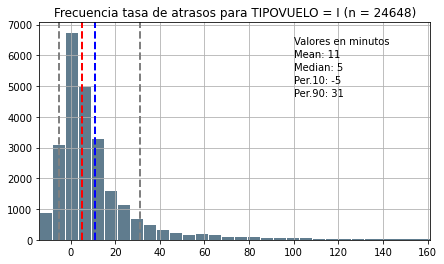

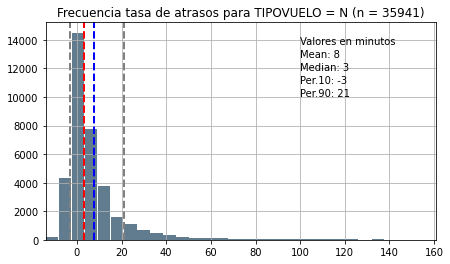

In [430]:
plot_by_cat_hist(df, var='dif_min', cat='TIPOVUELO')

**Al revisar las distribuciones de la varible continua de la diferencia entre el horario de vuelo planificado y operado, podemos concluir lo siguiente para cada clase en que se realizó el análisis:**

- **SIGLADES:** todas las distribuciones presentan un sesgo a la izquierda en el domo de sus histogramas, lo que implica una tendencia a los valores pequeños, este sesgo se puede obserbar tabularmente al ver que media y mediana difieren considerablemente y el percentil 90 de la distribución es muy escapado respecto a la mediana si lo comparamos con el percentil 10 (teorema del límite central). También concluimos que los mayores retrasos ocurren en vuelos internacionales, en este caso Sao Paulo, Buenos Aires y Lima.

- **OPERA:** nuevamente todas las distribuciones presentan un sesgo a la izquierda en el domo de sus histogramas, por las mismas razones explicadas en SIGLADES. en este caso la clase con más retrasos medios corresponde al operador Grupo LATAM.

- **MES:** se repite la tendencia del sesgo en las distribuciones por clase, siendo los meses con mayores retrasos julio, diciembre y octubre.

- **DIANOM:** se repite la tendencia del sesgo en las distribuciones por clase,los días que muestran mayores valores medios en sus retrasos son viernes, lunes y jueves.

- **temporada_alta:** se repite la tendencia del sesgo en las distribuciones por clase, como era de esperar, temporada alta presenta los mayores retrasos posiblemente por la mayor congestión generada en ésta.

- **TIPOVUELO:** se repite la tendencia del sesgo en las distribuciones por clase, los vuelos internacionales presentan mayores retrasos medios, especulando, esto podría ser debido a variables relacionadas con la logística más compleja requerida para este tipo de vuelos.

**A continuación se realizará un análisis de frecuencias para las clases vistas anteriormente pero esta vez relacionándolo con la variable atraso_15, donde consideraremos como atraso los vuelos que en el campo dif_min tengan valores mayores a 15 minutos**

In [431]:
# Función para graficar frecuencias de atrasos por clases
def atraso15_func(df, cat):
    plt.figure(figsize=(7, 4))
    sns.countplot(y=cat, hue='atraso_15', data=df)
    plt.title('Frecuencia para atraso para clase ' + str(cat))
    plt.grid(True)
    plt.show()

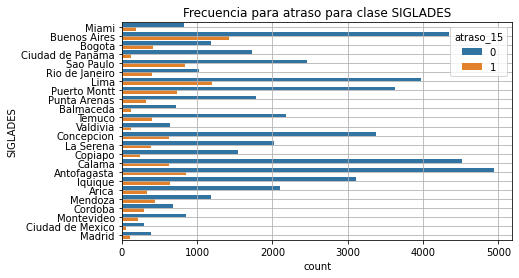

In [432]:
atraso15_func(df, cat='SIGLADES')

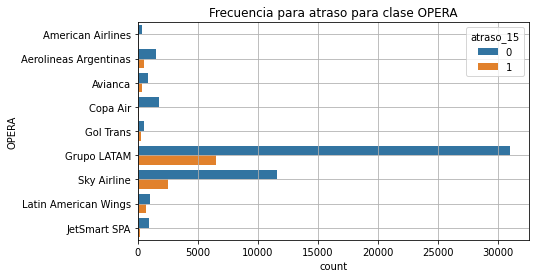

In [433]:
atraso15_func(df, cat='OPERA')

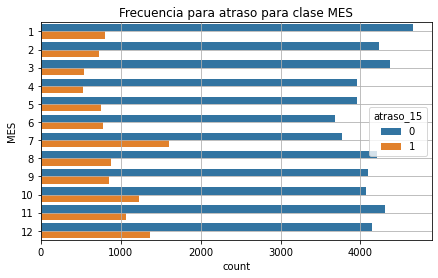

In [434]:
atraso15_func(df, cat='MES')

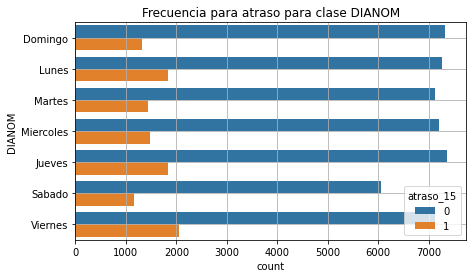

In [435]:
atraso15_func(df, cat='DIANOM')

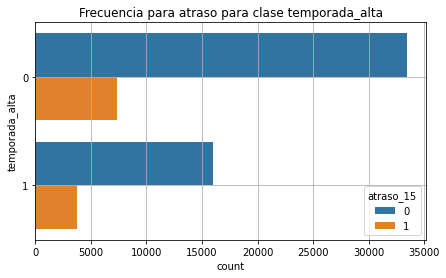

In [436]:
atraso15_func(df, cat='temporada_alta')

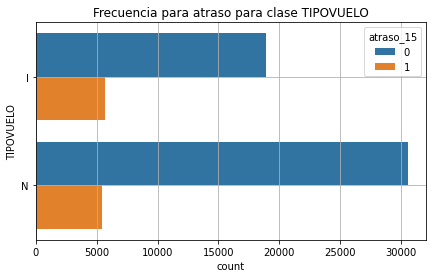

In [437]:
atraso15_func(df, cat='TIPOVUELO')

**Al ver las freciencias por clase para nuestro posible vector objetivo a modelar para la predicción de atrasos (atraso_15), se aprecia un gran desbalance en todas las posibles variables predictoras, lo que es un problema en la etapa de modelación ya que podría generar sesgos donde el modelo aprenda más de la clase mayoritaria (atraso 1) y por ende se equivoque más en la minoritaria (sin atraso 0).**

**Este problema podría ser tratado usando técnicas de downsample sobre categoría con más observaciones o de upsample sobre categoría con menos observaciones, pero en esta ocación al no tener suficiente información y conocimiento del problema (i.e. conocer heurísticamente el dominio de las variables) no se procederá a aplicar ninguna de estas técnicas ya que al hacerlo en las condiciones mencionadas podría generar aún más problemas en los datos.**

**Finalmente, de acuerdo a lo visto en la revisión de los datos, cinco de las seis variables evaluadas (SIGLADES, OPERA, MES, temporada_alta, TIPOVUELO) muestran algún grado de diferenciación en sus atrasos por lo que es posible que todas en mayor o menos medida tengan la capacidad de discriminarlos, más aún en variables latentes de ciertas combinaciones de ellas que algunos modelos de machine learnig son capaces de encontrar. DIANOM no muestra suficiente variabilidad al ver como distribuye por cada clase, por lo que para efectos de parsiminía se descartará como variable predictora**

# 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

In [446]:
import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve
from sklearn.utils import resample
from sklearn.utils import shuffle
import scikitplot as skplt

**En la etapa de modelación se entrenarán dos modelos y se realizará la comparación de la capacidad predictiva de ambos usando las variables predictoras que determinamos en el punto anterior. Los modelos seleccionados serán en primera instancia la regresión logística, modelo sencillo pero con gran robustez estadística por lo que es un buen punto de partida para una aproximación inicial a la capacidad discriminadora de nuestras variables seleccionadas. El segundo modelo corresponde a una red neuronal densa, modelo complejo de gran capacidad predictiva pero con alta tendencia al sobreajuste, problemas que deben ser manejados cuidadosamente en el entrenamiento. El motivo de la elección de estos dos modelos es ver si un modelo de alta complejidad es capaz de mejorar significativamente las predicciones respecto a un modelo más sencillo pero robusto.**

**Por otro lado, no se probarán más modelos modelos relativamente complejos como por ejemplo Random Forest, ya que hubiese tomado más tiempo del esperado debido a su proceso de optimizar hiperparámetros, el que habría sido muy costoso computacionalmente y haber tardado mucho por el tamaño de la data más el gran número de iteraciones que se deberían haber hecho**

**Primero realizaremos un downsampling para balancear los datos, quedando finalmente con la misma cantidad de observaciones para las dos clases de la variable atraso_15. Se utiliza este método ya que como se mencionó en otro punto, no tenemos conocimiento heurístico del dominio de las variables, por lo que remuestrear dentro de sus distribuciones podría generar sesgos no cuantificables o problemas que no podríamos discernir**

**Posteriormente transformaremos nuestras 5 variables predictoras a valores numéricos que los modelos puedan entender de acuerdo a lo siguiente:**

- **SIGLADES y MES:** con 12 y 12 clases respectivamente, se usará en ambas one-hot-encoding que si bien genera una alta dimensionalidad, es más correcto que usar otro método como label encoding ya que este último sólo debe usarse cuando se tiene conocimiento de la existencia de alguna jerarquía en las clases, es decir, clases ordinales.

- **OPERA y TIPOVUELO:** Ambas clases podeen dos categorías por lo que se convertiran en variables binarias de valores 0 y 1 para cada respectiva clase.

- **temporada_alta:** variable binaria 0 y 1, no necesita transformación.

- **Vector objetivo atraso_15:** variable binaria 0 y 1, no necesita transformación.

In [439]:
# Downsampling sobre clase con mayor cantidad de observaciones ()
atraso = df[df["atraso_15"] == 1]
noatraso  = df[df["atraso_15"] == 0]
print('Número de observaciones clase 1: ', atraso.shape[0])
print('Número de observaciones clase 0: ', noatraso.shape[0])

downsample = resample(noatraso, replace=True, n_samples=atraso.shape[0], random_state=42)
print('Número de observaciones clase 0 posterior a downsampling: ', downsample.shape[0])

df2 = pd.concat([downsample, atraso])
df2 = shuffle(df2)
print('Número de observaciones totales de dataframe final: ', df2.shape[0])

Número de observaciones clase 1:  11119
Número de observaciones clase 0:  49470
Número de observaciones clase 0 posterior a downsampling:  11119
Número de observaciones totales de dataframe final:  22238


In [319]:
# Generamos variables binarias
df2['OPERA2'] = np.where(df2['OPERA'] == df2['OPERA'].unique()[0], 0, 1)
df2['TIPOVUELO2'] = np.where(df2['TIPOVUELO'] == df2['TIPOVUELO'].unique()[0], 0, 1)

# Seleccionamos nuestras variables predictoras y nuestro vector objetivo en distintos objetos
X = df2[['temporada_alta', 'OPERA2', 'TIPOVUELO2', 'SIGLADES', 'MES']]#, 'DIANOM']]
Y = df2['atraso_15']

# Generamos variables dummie de SIGLADESy MES
X = pd.concat([X, pd.get_dummies(X['SIGLADES'],prefix="SIGLADES")],axis=1)
X.drop('SIGLADES', axis=1, inplace=True)
X = pd.concat([X, pd.get_dummies(X['MES'],prefix="MES")],axis=1)
X.drop('MES', axis=1, inplace=True)

print(X.columns)

# Convertimos data frames en arreglos numpy
X = X.values
Y = Y.values

# Creamos datas de test y train dejando un 30% y 70% respectivamente
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print('Train: ', x_train.shape, y_train.shape)
print('Test: ', x_test.shape, y_test.shape)  

Index(['temporada_alta', 'OPERA2', 'TIPOVUELO2', 'SIGLADES_Antofagasta',
       'SIGLADES_Arica', 'SIGLADES_Balmaceda', 'SIGLADES_Bogota',
       'SIGLADES_Buenos Aires', 'SIGLADES_Calama', 'SIGLADES_Ciudad de Mexico',
       'SIGLADES_Ciudad de Panama', 'SIGLADES_Concepcion', 'SIGLADES_Copiapo',
       'SIGLADES_Cordoba', 'SIGLADES_Iquique', 'SIGLADES_La Serena',
       'SIGLADES_Lima', 'SIGLADES_Madrid', 'SIGLADES_Mendoza',
       'SIGLADES_Miami', 'SIGLADES_Montevideo', 'SIGLADES_Puerto Montt',
       'SIGLADES_Punta Arenas', 'SIGLADES_Rio de Janeiro',
       'SIGLADES_Sao Paulo', 'SIGLADES_Temuco', 'SIGLADES_Valdivia', 'MES_1',
       'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9',
       'MES_10', 'MES_11', 'MES_12'],
      dtype='object')
Train:  (15566, 39) (15566,)
Test:  (6672, 39) (6672,)


**Entrenamos regresión logística con data train y evaluamos sus métricas de desempeño con data test**

In [448]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
test_pred_log = logreg.predict(x_test)
print(classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      3356
           1       0.60      0.60      0.60      3316

    accuracy                           0.60      6672
   macro avg       0.60      0.60      0.60      6672
weighted avg       0.60      0.60      0.60      6672



**Entrenamos red neuronal de la misma forma. Usamos funciones de activacion ReLU en capas internas y función de activaión sigmoide en capa de salida para clasificación binaria, de usa además como método de regularización de sobreajuste un dropout de 60% y el callback EarlyStopping con una patience de 20 épocas (esto último permite a entrenamiento detenerse si dentro de 20 épocas no hay una mejora, restaurando además los últimos mejores pesos obtenidos), finalmente el optimizador a usar es adam y la función de pérdida la entropía cruzada binaria.**

In [441]:
# Define a simple sequential model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# instanciamos modelo
model = create_model()

# instanciamos callback earlystopping con paciencia de 20 épocas
checkpoint = EarlyStopping(monitor='val_loss', min_delta=0,  patience=20, mode='min', restore_best_weights=True)
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 64)                2560      
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 64)              

In [442]:
# Entrenamos modelo
history = model.fit(x_train, y_train, epochs=160, callbacks=[checkpoint], batch_size=400, verbose=1, validation_split=0.3)

Train on 10896 samples, validate on 4670 samples
Epoch 1/160
10896/10896 [==============================] - 1s 100us/step - loss: 0.8292 - accuracy: 0.5190 - val_loss: 0.6927 - val_accuracy: 0.5099
Epoch 2/160
10896/10896 [==============================] - 0s 22us/step - loss: 0.7424 - accuracy: 0.5297 - val_loss: 0.6930 - val_accuracy: 0.5099
Epoch 3/160
10896/10896 [==============================] - 0s 22us/step - loss: 0.7233 - accuracy: 0.5392 - val_loss: 0.6918 - val_accuracy: 0.5180
Epoch 4/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.7158 - accuracy: 0.5524 - val_loss: 0.6906 - val_accuracy: 0.5482
Epoch 5/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.7116 - accuracy: 0.5497 - val_loss: 0.6887 - val_accuracy: 0.5420
Epoch 6/160
10896/10896 [==============================] - 0s 22us/step - loss: 0.7062 - accuracy: 0.5578 - val_loss: 0.6869 - val_accuracy: 0.5799
Epoch 7/160
10896/10896 [==============================] - 0s 

Epoch 56/160
10896/10896 [==============================] - 0s 20us/step - loss: 0.6520 - accuracy: 0.6221 - val_loss: 0.6596 - val_accuracy: 0.6133
Epoch 57/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.6513 - accuracy: 0.6200 - val_loss: 0.6585 - val_accuracy: 0.6146
Epoch 58/160
10896/10896 [==============================] - 0s 20us/step - loss: 0.6509 - accuracy: 0.6177 - val_loss: 0.6589 - val_accuracy: 0.6171
Epoch 59/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.6507 - accuracy: 0.6202 - val_loss: 0.6588 - val_accuracy: 0.6169
Epoch 60/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.6517 - accuracy: 0.6219 - val_loss: 0.6589 - val_accuracy: 0.6152
Epoch 61/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.6531 - accuracy: 0.6190 - val_loss: 0.6586 - val_accuracy: 0.6150
Epoch 62/160
10896/10896 [==============================] - 0s 21us/step - loss: 0.6507 - accuracy: 0.6197

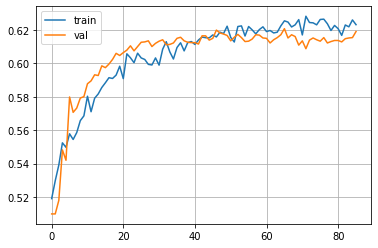

In [443]:
# visualizamos curvas mejoras en accuracy en datas test y train en el entrenamiento para verificar que no haya sobreajuste
mse = history.history['accuracy']
mse_val = history.history['val_accuracy']
plt.figure()
plt.plot(mse[:], label='train')
plt.plot(mse_val[:], label='val')
plt.legend()
plt.grid(True)
plt.show()

In [449]:
test_pred_rn = model.predict(x_test)
test_pred_rn = np.where(test_pred_rn>0.5,1,0)
print(classification_report(y_test, test_pred_rn))

              precision    recall  f1-score   support

           0       0.63      0.58      0.60      3356
           1       0.60      0.65      0.63      3316

    accuracy                           0.61      6672
   macro avg       0.62      0.61      0.61      6672
weighted avg       0.62      0.61      0.61      6672



**Generamos curvas ROC para ambos modelos**

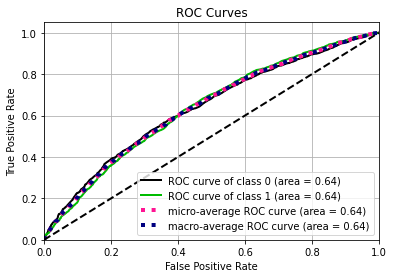

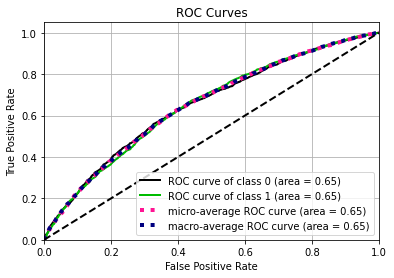

In [447]:
roc_rn = model.predict(x_test)
roc_rn = np.c_[ 1-roc_rn, roc_rn ]

skplt.metrics.plot_roc_curve(y_test, logreg.predict_proba(x_test))
plt.grid(True)
plt.show()
skplt.metrics.plot_roc_curve(y_test, roc_rn)
plt.grid(True)
plt.show()

# 5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué́? ¿Por qué́ elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

**Citando lo expuesto en el punto anterior, los modelos seleccionados fueron una regresión logística y una red neuronal densa, siendo el motivo de la elección de estos modelos el ver si un modelo de alta complejidad es capaz de mejorar significativamente las predicciones respecto a un modelo más sencillo pero robusto.**

**Las métricas que se usarán para evaluer los modelos será en primera instancia el accuracy de cada modelo, su precisión, que nos indica el desempeño que tiene al clasificar cada clase por separado donde lo esperado es que la capacidad predictiva de cada clase sea similar y no presente tendencia a predecir mejor una que otra. También se avaluará cómo se comporta la métrica f1 que es entérminos generales es una ponderación entre precisión y recall entregándonos un buen indicador general, y finalmente una curva ROC para cada modelo, donde la evaluación consiste en ver porcentualmente el área bajo la curva que generan las predicciones de los modelos siendo mejor quien se acerque más a 1, valor que implica la totalidad del área y por ende una capacidad de predicción "perfecta".**

**Todas las evaluacones de métricas de desempeño se realizarán con el set de test**

Métricas de desempeño regresión logística
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      3356
           1       0.60      0.60      0.60      3316

    accuracy                           0.60      6672
   macro avg       0.60      0.60      0.60      6672
weighted avg       0.60      0.60      0.60      6672



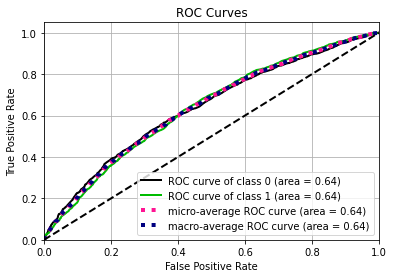

------------------------------------------------------------
Métricas de desempeño red neuronal
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      3356
           1       0.60      0.65      0.63      3316

    accuracy                           0.61      6672
   macro avg       0.62      0.61      0.61      6672
weighted avg       0.62      0.61      0.61      6672



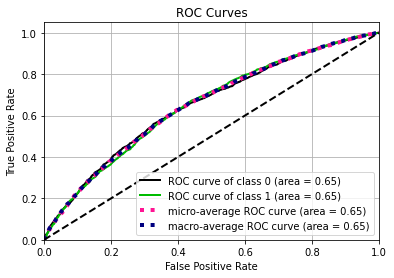

In [453]:
print('Métricas de desempeño regresión logística')
print(classification_report(y_test, test_pred_log))
skplt.metrics.plot_roc_curve(y_test, logreg.predict_proba(x_test))
plt.grid(True)
plt.show()
print('-'*60)
print('Métricas de desempeño red neuronal')
print(classification_report(y_test, test_pred_rn))
skplt.metrics.plot_roc_curve(y_test, roc_rn)
plt.grid(True)
plt.show()

**En términos generales el desempeño de ambos modelos es similar, si vemos el accuracy la regresión logística tieme un 60% mientras que la red neuronal a pesar de su mayor complejidad sólo inv¿crementa a un 61%. En cuanto a la precisión y el f1-score las métricas siguen mostrando valores muy similares, aunque si vemos el detalle por clases, la regresión logística tiende a ser mucho más robusta entregando los mismos valores para atraso (1) y no atraso (0). Igual que en las métricas de desempeño, al observar las curvas ROC de ambos modelos vemos que el área bajo la curva que genera la regresión logística es de un 64% mientras que la de la red neuronal es de un 65%.**

**Con la evaluación anterior podemos obtener dos conclusiones:**

- **La primera es que al tener ambos modelos métricas de desempeño muy similares, de elegir uno la mejor opción es la regresión logística, esto primero para apelar al principio de parsimonía y escoger el modelo más simple en caso de no haber diferencias significativas y lo segundo porque este modelo presenta una mejor robustez en la predicción de ambas clases**

- **La segunda conclusión es que ambos modelos poseen un desempeño muy bajo, incluso la red neuronal que podría haber dado mejores resultados respecto al modelo menos complejo. Para mejorar el dempeño podemos en primera instancia inspecionar las decisiones que se realizaron en el trabajo de depuración de los datos conversando con personas que tengan alto conocimiento del problema y replantenado decisiones en casos que sea necesario, lo segundo es obtener nuevas variables que nos entreguen más información y mejor capacidad para discriminar las clases, ejemplos de esto podría ser variables geoespaciales y climáticas como la distancia de los destinos y el clima, por mencionar algunos, el decidir que nuevas variables agregar y cómo obtenerlas requeriría nuevamente un trabajo exhaustivo con personas que conozcan muy bien el negocio para ver opciones y la viabilidad para obtener los datos.**